In [1]:
import pandas as pd
import os
import gc
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
import math         
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [5]:
if not os.path.exists('train_mold_data.csv') & True:
    train_file_name = []
    for file in tqdm(os.listdir('./Train/')):  
        if 'mold_data' in file:
            path = './Train/'+file
            fr = open(path,'rb').read()
            with open('train_mold_data.csv','ab') as f:
                f.write(fr) 
            fr = open(path)
            train_file_name += len(fr.readlines()) * [path]

    test_file_name = []
    for file in tqdm(os.listdir('./Test初赛/')):  
        if 'mold_data' in file:
            path = './Test初赛/'+file
            fr = open(path,'rb').read()
            with open('test_mold_data.csv','ab') as f:
                f.write(fr) 
            fr = open(path)
            test_file_name += len(fr.readlines()) * [path]

    train_mold_data = pd.read_csv('train_mold_data.csv')
    train_mold_data['file_name'] = np.array(train_file_name[1:])
    train_mold_data = train_mold_data[train_mold_data.SampleTime!='SampleTime']

    test_mold_data = pd.read_csv('test_mold_data.csv')
    test_mold_data['file_name'] = np.array(test_file_name[1:])
    test_mold_data = test_mold_data[test_mold_data.SampleTime!='SampleTime']

    train_mold_data.to_csv('train_mold_data.csv', index=False)
    test_mold_data.to_csv('test_mold_data.csv', index=False)
else:
    print('read csv train_mold_data.csv...')
    train_mold_data = pd.read_csv('train_mold_data.csv')
    test_mold_data = pd.read_csv('test_mold_data.csv')

read csv train_mold_data.csv...


In [4]:
# 机台工艺设定参数（data_set）：文件夹中含有注塑成型的81种工艺设定参数；
train_data_set = pd.read_csv('./Train/data_set.csv')
# 成型机状态数据（data_spc）：该数据来自成型机机台，均为表征成型过程中的一些状态数据，每一行对应一个模次，数据维度为86维；
train_data_spc = pd.read_csv('./Train/data_spc.csv')
train_size = pd.read_csv('./Train/Size.csv')

test_data_set = pd.read_csv('./Test初赛/data_set.csv')
test_data_spc = pd.read_csv('./Test初赛/data_spc.csv')

sub_file = pd.read_csv('sub_file.csv')

## 数据预处理

In [5]:
# 均为空的特征 
null_cols = ['EL_IV_END_TIME','EL_VPS_TIME','EL_GET_PART_TIME','ext_mold_temp_flt_4','ext_mold_temp_flt_5','ext_mold_temp_flt_6','ext_mold_temp_flt_7']

train_data_spc = train_data_spc[[f for f in train_data_spc.columns if f not in null_cols]]
test_data_spc = test_data_spc[[f for f in test_data_spc.columns if f not in null_cols]]

In [6]:
# 属性唯一的特征 
low_nunique_cols = []
for f in test_data_spc.columns:
    if test_data_spc[f].nunique() == 1:
        low_nunique_cols.append(f)

train_data_spc = train_data_spc[[f for f in train_data_spc.columns if f not in low_nunique_cols]]
test_data_spc = test_data_spc[[f for f in test_data_spc.columns if f not in low_nunique_cols]]

In [7]:
# mold_data  属性唯一的特征
del_cols = ['MouldFlow2','MouldFlow3']
train_mold_data = train_mold_data[[f for f in train_mold_data.columns if f not in del_cols]]
test_mold_data = test_mold_data[[f for f in test_mold_data.columns if f not in del_cols]]

In [8]:
train_mold_data['Id'] = train_mold_data['file_name'].apply(lambda x: int(x.split('_')[-1][:-4]))
test_mold_data['Id'] = test_mold_data['file_name'].apply(lambda x: int(x.split('_')[-1][:-4]))

## 获取所属机台参数

In [9]:
# 可用参数
set_cols = []
for f in train_data_set.columns:
    if train_data_set[f].nunique() > 1:
        if f != 'Id':
            set_cols.append(f)

In [10]:
df = pd.concat([train_data_spc, test_data_spc], axis=0, ignore_index=False)
min_id = df['Id'].min()
max_id = df['Id'].max()+1

# 两区间内机台参数一致
cup_id_li = [min_id] + train_data_set['Id'].tolist() + [max_id]

In [11]:
train_data_spc['true_Id'] = 0
test_data_spc['true_Id'] = 0
for i in range(len(cup_id_li)-1):
    id1 = cup_id_li[i]
    id2 = cup_id_li[i+1]
    train_data_spc.loc[(train_data_spc['Id']>=id1)&(train_data_spc['Id']<id2), 'true_Id'] = i
    test_data_spc.loc[(test_data_spc['Id']>=id1)&(test_data_spc['Id']<id2), 'true_Id'] = i

In [12]:
train_data_set = train_data_set.reset_index()
train_data_set['index'] = train_data_set['index'] + 1
train_data_set = train_data_set.rename(columns={'index':'true_Id'})

train_data_spc = train_data_spc.merge(train_data_set[set_cols+['true_Id']], on='true_Id', how='left')
test_data_spc = test_data_spc.merge(train_data_set[set_cols+['true_Id']], on='true_Id', how='left')

## 特征提取

### 依据mold_data数据提取序列相关特征

In [14]:
def groupby_feat1(df_, col):
    
    df = df_.copy()
    
    agg_df = df.groupby(['Id'])[col].agg(
        {'mean',
         'median',
         'max',
         'min',
         'nunique',
         'std',
         lambda x: np.quantile(x, 0.10),
         lambda x: np.quantile(x, 0.20),
         lambda x: np.quantile(x, 0.30),
         lambda x: np.quantile(x, 0.40),
         lambda x: np.quantile(x, 0.50),
         lambda x: np.quantile(x, 0.60),
         lambda x: np.quantile(x, 0.70),
         lambda x: np.quantile(x, 0.80),
         lambda x: np.quantile(x, 0.90)}
        ).reset_index()
    
    agg_df.columns = ['Id'] + [col + '_' + f for f in agg_df.columns.values if f != 'Id']
    
    return  agg_df 

def groupby_feat2(df_):
    
    df = df_.copy()
    
    agg_func = {
        'SampleTime':      ['count','max','std'],
        'Phase':           ['mean','max','nunique','std']
        } 
    
    agg_df = df.groupby(['Id']).agg(agg_func).reset_index()
    agg_df.columns = ['_'.join(f).strip() for f in agg_df.columns.values]
    agg_df = agg_df.rename(columns={'Id_':'Id'})
    
    return agg_df

In [18]:
cols = ['Sensor1','Sensor2','Sensor3','IJ','Sensor5','Sensor6','MouldTemp1','MouldTemp2','MouldTemp3','MouldTemp4','MouldTemp5',\
        'MouldTemp9','MouldTemp10','MouldTemp11','MouldTemp12','MouldTemp13','MouldTemp14','Sensor8','MouldFlow1','SP']
agg_df_cols = []
for col in tqdm(cols):
    
    train_mold_data[col] = train_mold_data[col].astype(float).apply(lambda x:round(x, 3))
    test_mold_data[col] = test_mold_data[col].astype(float).apply(lambda x:round(x, 3))
    
    agg_df = groupby_feat1(train_mold_data, col)
    train_data_spc = train_data_spc.merge(agg_df, on='Id', how='left')
    
    agg_df_cols += [f for f in agg_df.columns if f != 'Id']
    
    agg_df = groupby_feat1(test_mold_data, col)
    test_data_spc = test_data_spc.merge(agg_df, on='Id', how='left')

100%|██████████| 20/20 [24:27<00:00, 72.85s/it]


In [19]:
# SampleTime Phase Id2 相关特征
agg_df = groupby_feat2(train_mold_data)
train_data_spc = train_data_spc.merge(agg_df, on='Id', how='left')

agg_df = groupby_feat2(test_mold_data)
test_data_spc = test_data_spc.merge(agg_df, on='Id', how='left')

### train_data_spc相关特征

In [25]:
data_spc = pd.concat([train_data_spc, test_data_spc], axis=0, ignore_index=True)
data_spc = data_spc.merge(train_size, on='Id', how='left')

In [28]:
cols = ['Id','spcTime','EL_CLAMP_PRESS','IJ_<lambda_0>','IJ_nunique','Sensor6_<lambda_6>']
# cols = ['Id','spcTime','EL_CLAMP_PRESS'] + agg_df_cols
cut_cols = ['true_Id']
for col in cols:
    data_spc['cut_'+col] = pd.cut(data_spc[col], 100, labels=False)
    cut_cols.append('cut_'+col)

# data_spc['size12'] = data_spc['size1'] + data_spc['size2']
# data_spc['size13'] = data_spc['size1'] + data_spc['size3']
# data_spc['size23'] = data_spc['size2'] + data_spc['size3']
# data_spc['size123'] = data_spc['size1'] + data_spc['size2'] + data_spc['size3']

# data_spc['size1_2'] = data_spc['size1'] / data_spc['size2']
# data_spc['size1_3'] = data_spc['size1'] / data_spc['size3']
# data_spc['size2_3'] = data_spc['size2'] / data_spc['size3']

In [29]:
mean_columns = []
for col1 in tqdm(cut_cols):
    for col2 in ['size1','size2','size3']:
        col_name = col1+'_'+col2+'_median'
        mean_columns.append(col_name)
        order_label = data_spc.groupby([col1])[col2].median()
        data_spc[col_name] = data_spc[col1].map(order_label)
        
        col_name = col1+'_'+col2+'_mean'
        mean_columns.append(col_name)
        order_label = data_spc.groupby([col1])[col2].mean()
        data_spc[col_name] = data_spc[col1].map(order_label)
        
for col in ['size1','size2','size3']:
    del data_spc[col]

100%|██████████| 7/7 [00:00<00:00, 78.49it/s]


In [30]:
train_data_spc = data_spc[:train_data_spc.shape[0]]
test_data_spc = data_spc[train_data_spc.shape[0]:]

## 训练集&验证集

In [51]:
train_size['size1_label'] = train_size['size1']
train_size['size2_label'] = train_size['size2']
train_size['size3_label'] = train_size['size3']

In [52]:
features = [f for f in train_data_spc.columns if f not in ['adjust_reasons','versionTime']]

## 模型训练

In [53]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'regression_l2',
                'metric': 'mae',
                'num_leaves': 2**8-1,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'learning_rate': 0.01,
                'seed': 2020,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=500, early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(test_data_spc.columns, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x.values , label=trn_y)
            valid_matrix = clf.DMatrix(val_x.values , label=val_y)
            test_matrix = clf.DMatrix(test_x.values)
            
            params = {'booster': 'gbtree',
                      'eval_metric': 'mae',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 8,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.01,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=500, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
                 
            
        train[valid_index] = val_pred
        test += test_pred / kf.n_splits
        cv_scores.append(mean_absolute_error(val_y, val_pred))
        
        print(cv_scores)
       
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [54]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

In [55]:
lgb_train, lgb_test = lgb_model(train_data_spc[features], train_size['size1_label'], test_data_spc[features])
# 0.013393978245265305
# 0.013323751647949165
# 0.01328425039177308

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00628886	valid_1's l1: 0.0132544
Early stopping, best iteration is:
[633]	training's l1: 0.00512135	valid_1's l1: 0.0132469
[0.013246479027307018]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00622441	valid_1's l1: 0.0132671
Early stopping, best iteration is:
[594]	training's l1: 0.00535957	valid_1's l1: 0.0132436
[0.013246479027307018, 0.013243713162545665]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00620515	valid_1's l1: 0.0136527
Early stopping, best iteration is:
[508]	training's l1: 0.00612545	valid_1's l1: 0.0136495
[0.013246479027307018, 0.013243713162545665, 0.013649547916273605]
*******

In [56]:
lgb_train2, lgb_test2 = lgb_model(train_data_spc[features], train_size['size2_label'], test_data_spc[features])
# 0.014134515989711507
# 0.014042814206327331
# 0.014062382321726016

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00670393	valid_1's l1: 0.0144163
[1000]	training's l1: 0.0031165	valid_1's l1: 0.0143976
Early stopping, best iteration is:
[949]	training's l1: 0.00335957	valid_1's l1: 0.0143955
[0.014395475852839484]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.006754	valid_1's l1: 0.0140551
[1000]	training's l1: 0.00313994	valid_1's l1: 0.0140301
Early stopping, best iteration is:
[972]	training's l1: 0.00327314	valid_1's l1: 0.0140288
[0.014395475852839484, 0.014028740164860066]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00670888	valid_1's l1: 0.0141631
Early stopping, best iteration is:
[437]	training's l1

In [57]:
lgb_train3, lgb_test3 = lgb_model(train_data_spc[features], train_size['size3_label'], test_data_spc[features])
# 0.012495826819060672
# 0.012430200764916783
# 0.012436420627116453

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00583644	valid_1's l1: 0.0125424
Early stopping, best iteration is:
[621]	training's l1: 0.00482721	valid_1's l1: 0.0125206
[0.01252055399751501]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00585627	valid_1's l1: 0.012409
Early stopping, best iteration is:
[723]	training's l1: 0.00413916	valid_1's l1: 0.0123842
[0.01252055399751501, 0.012384091458755167]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00586148	valid_1's l1: 0.0124636
Early stopping, best iteration is:
[650]	training's l1: 0.00463665	valid_1's l1: 0.0124585
[0.01252055399751501, 0.012384091458755167, 0.012458579215455382]
***********

In [58]:
# xgb_train, xgb_test = xgb_model(train_data_spc[features], train_size['size1_label'], test_data_spc[features])
# xgb_train2, xgb_test2 = xgb_model(train_data_spc[features], train_size['size2_label'], test_data_spc[features])
# xgb_train3, xgb_test3 = xgb_model(train_data_spc[features], train_size['size3_label'], test_data_spc[features])

In [65]:
sub_file['size1'] = lgb_test
sub_file['size2'] = lgb_test2
sub_file['size3'] = lgb_test3

In [66]:
sub_file.to_csv('sub.csv', index=False)

In [67]:
print(lgb_test.min())
print(lgb_test.max())
print(lgb_test.mean())

299.9929727328714
300.12487893181634
300.0416077182137


In [62]:
print(lgb_train.min())
print(lgb_train.max())
print(lgb_train.mean())

299.9180458717305
300.2928222825374
300.06550391759436


In [63]:
sub_file.describe()

,Id,size1,size2,size3
count,3953.000000,3953.000000,3953.000000,3953.000000
mean,112006.362004,300.041608,200.018514,199.999860
std,45220.694044,0.027741,0.052422,0.016632
min,56689.000000,299.992973,199.967867,199.973543
25%,83514.000000,300.012995,199.981773,199.983474
50%,89799.000000,300.049118,199.986686,200.002195
75%,160716.000000,300.057091,200.095970,200.010374
max,176241.000000,300.124879,200.138697,200.099137


In [64]:
train_size.describe()

,size1,size2,size3,Id,size1_label,size2_label,size3_label
count,16600.000000,16600.000000,16600.000000,16600.000000,16600.000000,16600.000000,16600.000000
mean,300.065520,200.005452,200.017767,62946.797048,300.065520,200.005452,200.017767
std,0.041601,0.052606,0.035177,33660.419640,0.041601,0.052606,0.035177
min,299.867000,199.836000,199.872000,33722.000000,299.867000,199.836000,199.872000
25%,300.041000,199.969000,199.996000,43203.750000,300.041000,199.969000,199.996000
50%,300.066000,199.998000,200.015000,49144.500000,300.066000,199.998000,200.015000
75%,300.088000,200.027000,200.035250,56481.500000,300.088000,200.027000,200.035250
max,300.610000,200.191000,200.225000,150716.000000,300.610000,200.191000,200.225000


## 数据分析

In [44]:
train_size[train_size.Id.isin(['33722','146291'])]

,size1,size2,size3,Id
0,299.998,199.995,199.967,33722
15472,300.085,200.114,200.034,146291


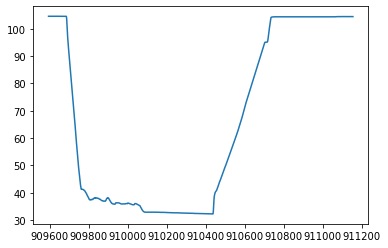

In [98]:
train_mold_data[train_mold_data.file_name=='./Train/mold_data_611173927_37559.csv']['SP'].astype(float).plot()

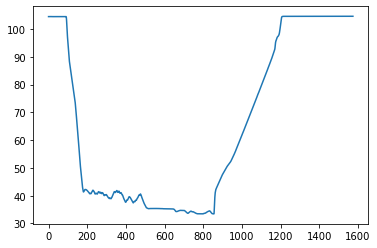

In [91]:
test_mold_data[test_mold_data.file_name=='./Test初赛/mold_data_611924900_56689.csv']['SP'].astype(float).plot()

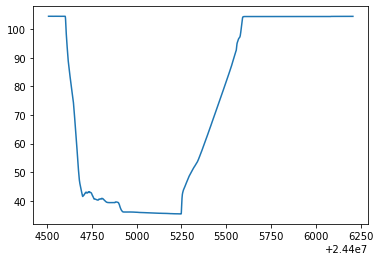

In [100]:
train_mold_data[train_mold_data.file_name=='./Train/mold_data_617382049_146291.csv']['SP'].astype(float).plot()

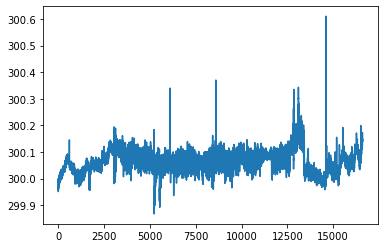

In [47]:
train_size['size1'].plot()

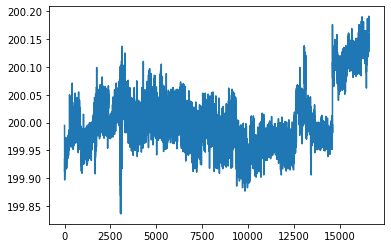

In [48]:
train_size['size2'].plot()

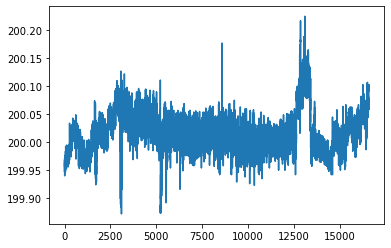

In [49]:
train_size['size3'].plot()

In [67]:
sub_file

,Id,size1,size2,size3
0,56689,1,1,1
1,56691,1,1,1
2,56697,1,1,1
3,56698,1,1,1
4,56701,1,1,1
...,...,...,...,...
3948,175911,1,1,1
3949,175961,1,1,1
3950,176111,1,1,1
3951,176131,1,1,1
